In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import math

In [117]:
particle_diameter = 0.1e-6 # m
particle_density = 997 # kg/m^3
particle_cross_section_area = math.pi*(particle_diameter/2)**2
particle_volume =4/3*math.pi*(particle_diameter/2)**3
particle_mass = particle_volume*particle_density
fluid_density = 1.255 # kg/m^3

dynamic_viscosity_air_25C = 1.849e-5
mean_free_path_air_25C = 6.826e-8

reynolds_max = None
reynolds_min = None

In [118]:
Re = lambda v: fluid_density*v*particle_diameter/dynamic_viscosity_air_25C  #not entirely accurate

# Slip correction factor
C_c = 1 + 2*mean_free_path_air_25C/particle_diameter*(1.257+0.4*math.e**(-1.1*particle_diameter/(2*mean_free_path_air_25C)))


def C_d(Re):
    global reynolds_max 
    global reynolds_min
    if reynolds_max is None or Re > reynolds_max:
        reynolds_max = Re
    if reynolds_min is None or Re < reynolds_min:
        reynolds_min = Re
    if Re < 0.1:
        return 24/Re
    elif Re > 0.1 and Re < 0.2:
        return 24/Re*(1+3/16*Re+9/160*Re**2*np.log(2*Re))
    elif Re > 0.2 and Re < 500:
        return 24/Re*(1+0.15*Re**0.686)
    elif Re > 500 and Re < 2e5:
        return 0.44
    reynolds_to_large = True
    raise Exception('Reynolds number to large')
        
def F_drag(v):
    # also add drag force = 0 if velocity is 0
    if particle_diameter < 10e-6:
        return 3*math.pi*dynamic_viscosity_air_25C*v*particle_diameter/C_c
    else:
        return math.pi/8*C_d(Re(v))*fluid_density*particle_diameter**2*v**2

In [119]:
def euler(xy_n, delta_t, funcs):
    # 2D euler
    x_n = xy_n[0] + delta_t*funcs[0]
    y_n = xy_n[1] + delta_t*funcs[1]
    return [x_n, y_n]

#euler1D = lambda y_n, delta_t, func: y_n + delta_t*func

F_g_1 = 1/6*math.pi*particle_density*particle_diameter**3*constants.g
F_g = particle_mass*constants.g
F_d_8 = lambda v: (math.pi*C_d(Re(v))*particle_density*particle_diameter**2*v**2)/8
F_d_3 = lambda v: (3*math.pi*dynamic_viscosity_air_25C*particle_diameter*v)/22.7
F_d_wiki = lambda v: 1/2*particle_density*v**2*C_d(Re(v))*particle_cross_section_area
F_d_stoke = lambda v: 6*math.pi*dynamic_viscosity_air_25C*(particle_diameter/2)*v
F_b_paper = 1/6*math.pi*particle_diameter**3*fluid_density*constants.g
F_b = fluid_density*particle_volume*constants.g

In [120]:
def acceleration(v):
    speed = (v[0]**2+v[1]**2)**(1/2)
    velocity_unitvector_x = v[0]/speed
    velocity_unitvector_y = v[1]/speed
    #print((velocity_unitvector_x**2+velocity_unitvector_y**2)**(1/2))
    drag_force = F_drag(speed)
    drag_force_x = -1*velocity_unitvector_x*drag_force
    drag_force_y = -1*velocity_unitvector_y*drag_force
    #print(drag_force_x, drag_force_y)
    a_x = drag_force_x/particle_mass
    a_y = (-F_g + drag_force_y + F_b)/particle_mass
    #print(a_x, a_y)
    # compute the stoke based on speed (non vector) then drag force direction is inverse of velocity vector direction
    #a_x = -F_d_stoke(v[0])/particle_mass
    #a_x = 0
    #a_y = (-F_g+F_b+ F_d_wiki(v[1]))/particle_mass
    return [a_x, a_y]

In [121]:
t_total = 1
delta_t = 0.000001 #0.000001
steps = np.arange(0, t_total, delta_t)

In [122]:
v_init = [1, 1]
pos_init = [0, 10]
#a_init = [constants.g, 0]

n_steps = math.ceil(t_total/delta_t)
v = np.zeros(shape=(n_steps + 1, 2))
pos = np.zeros(shape=(n_steps + 1, 2))

v[0] = v_init
pos[0] = pos_init

In [123]:
def euler_step(v, pos):
    pos_new = euler(pos, delta_t, v)
    a_new = acceleration(v)
    v_new = euler(v, delta_t, a_new)
    
    return {
        'a': a_new,
        'v': v_new,
        'pos': pos_new
    }

for id, step in enumerate(steps):
    # compute new values
    #print(v[id])
    new_values = euler_step(v[id], pos[id])
    
    # add new values
    v[id+1] = new_values['v']
    pos[id+1] = new_values['pos']
    
print('finished')

if (reynolds_max and reynolds_min):
    print('reynolds_max', "{:e}".format(reynolds_max), 'reynolds_min', "{:e}".format(reynolds_min))

finished


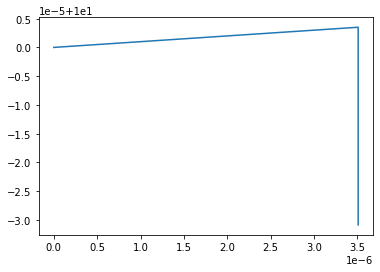

In [124]:
#position
fig, ax = plt.subplots()

# extract axes from position list
pos_x = list(map(lambda xy: xy[0], pos))
pos_y = list(map(lambda xy: xy[1], pos))

ax.plot(pos_x, pos_y)

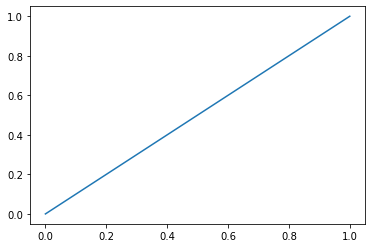

In [125]:
#velocity
fig, ax = plt.subplots()

# extract axes from position list
v_x = list(map(lambda xy: xy[0], v))
v_y = list(map(lambda xy: xy[1], v))

ax.plot(v_x, v_y)